In [31]:
#Import plotlib library and modules
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
#Import modules
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [36]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [37]:
# Save references to each table

Station = Base.classes.station
Measurement = Base.classes.measurement


In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [39]:
# Find the most recent date in the data set.
inspector = inspect(engine)

#Show column names
columns_measure = inspector.get_columns('measurement')

#Show data and types
for c in columns_measure:
    print(c['name'], c["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
#Query data from "measurement" data
session.query(Measurement.date, Measurement.prcp).filter(Measurement.prcp == None).limit(5).all()

[('2010-01-06', None),
 ('2010-01-30', None),
 ('2010-02-03', None),
 ('2010-02-19', None),
 ('2010-03-11', None)]

In [41]:
#Organize data from most recent to oldest
session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).limit(1).all()

[('2017-08-23', 0.0)]

In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
precip_score = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc())\
    .filter(Measurement.date > '2016-08-23').all()



# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip_score, columns=['Date', 'Precipitation'])
df.dropna(axis=0, how='any', inplace=True)
df = df.set_index('Date')

# Sort the dataframe by date
df.sort_values(by='Date', ascending=True, inplace=True)


# Display dataframe
df


,Precipitation
Date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,1.22
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


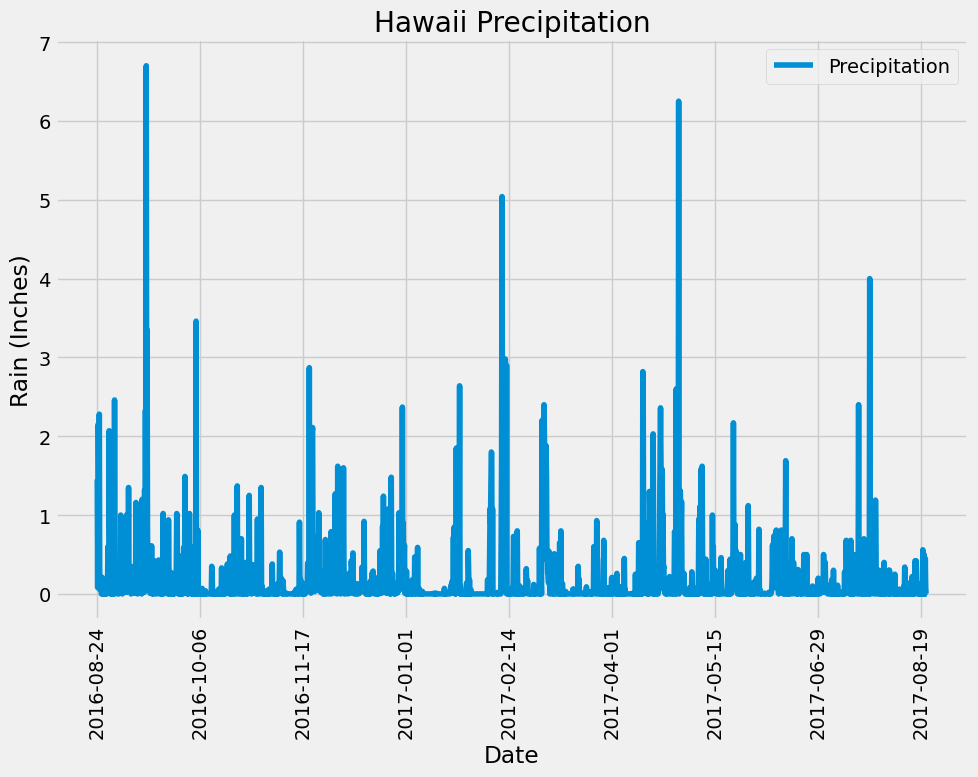

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(y='Precipitation', title='Hawaii Precipitation', rot = 90, figsize=(10,8))
plt.ylabel('Rain (Inches)')
plt.tight_layout()
# plt.show()
plt.savefig('precipitation')

In [44]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [45]:
# Design a query to calculate the total number stations in the dataset
columns_stat = inspector.get_columns('station')

#Show data and types
for c in columns_stat:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [46]:
#Fetching all data for stations
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [47]:
#Count how many total stations
session.query(Station.name).group_by(Station.name).count()
station_count = session.query(Measurement.station).group_by(Measurement.station).count()

print(f'There are {station_count} stations.')

There are 9 stations.


In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
#Find most active station
station_max = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).first()
print(f'Station ID {station_max[0]} is the most active station.')

Station ID USC00519281 is the most active station.


In [50]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#Query lowest temp at most active station
stat_low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_max[0]).first()
print(f' The lowest temperature at station ID {station_max[0]} was {stat_low[0]} degrees.')

#Query highest temp at most active station
stat_high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_max[0]).first()
print(f' The highest temperature at station ID {station_max[0]} was {stat_high[0]} degrees.')

#Query average temp at most active station
stat_average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_max[0]).first()
print(f' The average temperature at station ID {station_max[0]} was {stat_average[0]} degrees.')

 The lowest temperature at station ID USC00519281 was 54.0 degrees.
 The highest temperature at station ID USC00519281 was 85.0 degrees.
 The average temperature at station ID USC00519281 was 71.66378066378067 degrees.


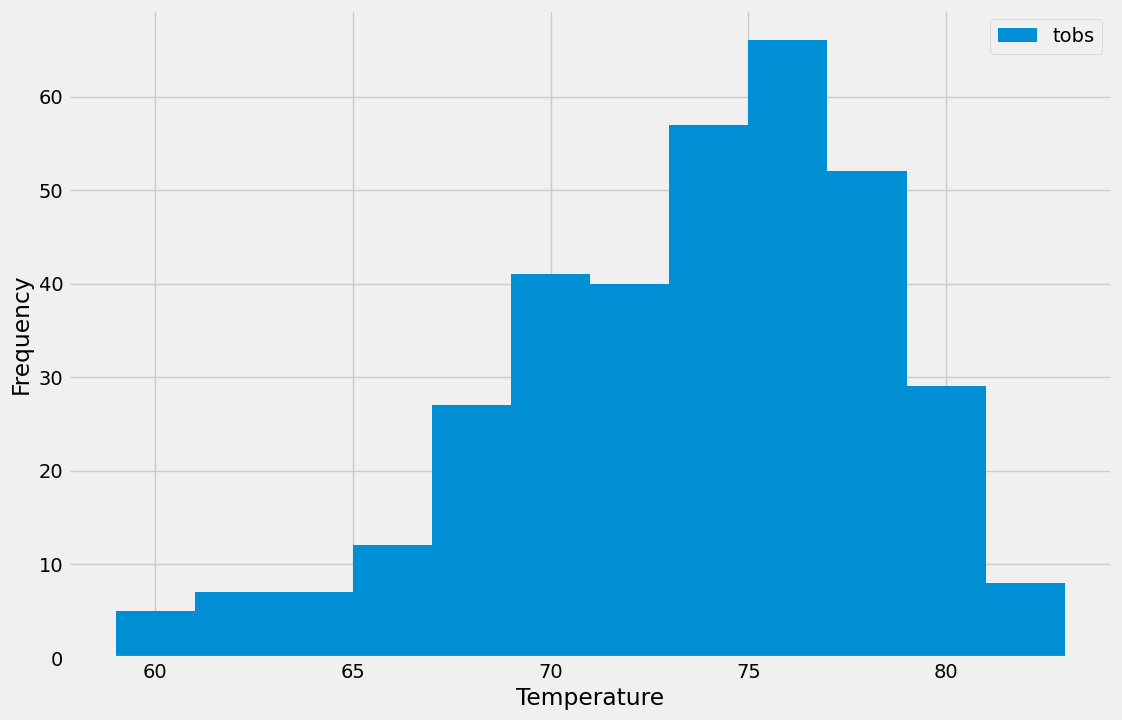

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.station == station_max[0])\
    .filter(Measurement.date > '2016-08-23')

station_graph = pd.read_sql(station.statement, station.session.bind)

#plot data on histogram
station_graph.plot.hist(bins=12, figsize=(12,8))
plt.xlabel('Temperature')
plt.savefig('Temperatures')


# Close Session

In [52]:
# Close Session
session.close()